# 1 Parameter setting

In [1]:
import os
import ppap4lmp as pp
import numpy as np
import matplotlib.pyplot as plt


In [3]:
cwd = os.getcwd()
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

path = "/home/yang/kimberly/mass_density_60_60/stea_0.5"

OFMnum = 60          # Number of OFMs ------ [92 for High; 46 for Medium; 22 for Low]

Files in '/home/yang/kimberly/mass_density_60_60/stea_0.5': ['Cal_NumberDensityDistribution_volume.ipynb', 'Analyze']


In [6]:
path_dumps = "/mnt/Kim_3/4.0_stearamide/60pao_60ofm/7.shear_0.5G_rerun/dumps_all"
os.chdir(path_dumps)
print(os.getcwd())

/mnt/Kim_3/4.0_stearamide/60pao_60ofm/7.shear_0.5G_rerun/dumps_all


In [7]:
# path_dumps = path + "/dumps_all"

if not os.path.exists(path + "/Analyze"):
    os.makedirs(path + "/Analyze")
path_Analyze = path + "/Analyze"

# os.chdir(path_dumps)
# print(os.getcwd())

In [8]:
dump_start = 9000000    
dump_end =   14000000
dump_interval = 2000

FilmThickness = 20 # Å, Can be a little bigger than real film thickness
#OFMnum = ?
gap = 0.1           # The interval of each layer

In [9]:
box_x = 130.813   # Å
box_y = 35.245   # Å

#Area = box_x * box_y   # Å^2, NOTE: It is better to use volume, not area! I have changed area to volume in EXCEL.

Volume = box_x * box_y * gap    # Å^3 在这个新的程序里面，改成了直接除以体积，避免在excel里重新算

print(Volume)

461.0504184999999


# 2 Program running

In [10]:
# 判断之前是否已经保存过基板的[最大][最小]坐标：若没有，则计算并输出保存；若有，则直接读取
# 因为计算一次要花很长时间

# 1. Find Max lower Fe
if not os.path.isfile(path_Analyze + "/Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
  
  os.chdir(path_dumps)
  atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

  for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {19}}))  # Type 17: Fe's type on lower interface

  pro = pp.ProValueArray(atoms_traj)
  pro.select("zu")
  pp.execute_omp(pro)
  results = pro.get_results()
  zu_array_Fe = results["zu"]

  MaxLowerFe = np.zeros(len(atoms_traj))
  for i in range(len(atoms_traj)):
      MaxLowerFe[i] = np.max(zu_array_Fe[i])  # Z_max for Fe in lower interface  
  print(MaxLowerFe)

  os.chdir(path_Analyze)
  np.savetxt("Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", MaxLowerFe, fmt='%f', delimiter=' ')

else:
  print("Will read MaxLowerFe directly from the previous saved file.")
  
  


Will read MaxLowerFe directly from the previous saved file.


In [11]:
# Read MaxLowerFe and MinUpperFe from file no matter re-calculated or not.

os.chdir(path_Analyze)
MaxLowerFe = np.loadtxt(
    "Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [12]:
# Get the smallest and largest x-coordinate of oxygen atoms in upper interface

os.chdir(path_dumps)
atoms_traj = [pp.create(
pp.StaDumpAtoms("atom.{}.dump".format(i), i))
for i in range(dump_start, dump_end+2000, dump_interval)]

for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {26}}))  # Type 24: O's type on upper cylinder surface

In [13]:
if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
    if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
        c = pp.ProValueArray(atoms_traj)
        c.select("xu")
        pp.execute_omp(c)
        results = c.get_results()
    
        xu_array_O = results["xu"]
        Min_Oxu = np.zeros(len(atoms_traj))
        Max_Oxu = np.zeros(len(atoms_traj))
        for i in range(len(atoms_traj)):
            Min_Oxu[i] = np.min(xu_array_O[i])
            Max_Oxu[i] = np.max(xu_array_O[i])
        print(Min_Oxu)
        print(Max_Oxu)
    
        os.chdir(path_Analyze)
        np.savetxt("Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Min_Oxu, fmt='%f', delimiter=' ')
        np.savetxt("Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Max_Oxu, fmt='%f', delimiter=' ')
else:
  print("Will read Min_Oxu,Max_Oxu directly from the previous saved file.")

Will read Min_Oxu,Max_Oxu directly from the previous saved file.


In [14]:
os.chdir(path_Analyze)
Min_Oxu = np.loadtxt(
    "Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)
Max_Oxu = np.loadtxt(
    "Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [15]:
#Cylinder下部のMin_Oxu,Max_OxuをWrap
for i in range (len(atoms_traj)):   
    if Min_Oxu[i] < 0:
        while Min_Oxu[i] < 0:
            Min_Oxu[i] +=  box_x
    elif Min_Oxu[i] > box_x:
        while Min_Oxu[i] > box_x:
            Min_Oxu[i] -= box_x

for i in range (len(atoms_traj)):   
    if Max_Oxu[i] < 0:
        while Max_Oxu[i] < 0:
         Max_Oxu[i] +=  box_x
    elif Max_Oxu[i] > box_x:
        while Max_Oxu[i] > box_x:
         Max_Oxu[i] -= box_x

print(Min_Oxu)
print(Max_Oxu)

[24.755 24.84  24.976 ...  1.066  1.166  1.326]
[59.621 59.855 60.    ... 36.046 36.216 36.346]


## 2.1 Cal mass density profile for PAO atoms

In [16]:
os.chdir(path_dumps)
atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

In [17]:
len(atoms_traj)

2501

In [18]:
for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {1,2,3,4,5}}))  
    # 1: C     2: C     3: H

pro = pp.ProValueArray(atoms_traj)
pro.select("zu","type","xu")

pp.execute_omp(pro)

results = pro.get_results()

zu_array = results["zu"]
type_array = results["type"]
xu_array = results["xu"]

print(type_array)

[[2. 3. 3. ... 4. 4. 4.]
 [2. 3. 3. ... 4. 4. 4.]
 [2. 3. 3. ... 4. 4. 4.]
 ...
 [2. 3. 3. ... 4. 4. 4.]
 [2. 3. 3. ... 4. 4. 4.]
 [2. 3. 3. ... 4. 4. 4.]]


In [19]:
# total number of atoms selected 
num_elements = len(zu_array)
print(num_elements)
atom_num = 7320            # 1: C     2: C     3: H

2501


In [20]:
for i in range (len(atoms_traj)):   
    for j in range (atom_num):    #7320
        if xu_array[i][j] < 0:
            while xu_array[i][j]<0:
                xu_array[i][j] = xu_array[i][j]+box_x
        elif xu_array[i][j] > box_x:
            while xu_array[i][j]>box_x:
                xu_array[i][j] -= box_x
        xu_array[i][j] = round(xu_array[i][j], 4)
print(xu_array)

[[  4.393   3.71    2.23  ... 110.631 110.028 109.505]
 [  4.017   2.781   1.444 ... 110.923 111.637 110.346]
 [  4.797   3.886   2.499 ... 110.052 110.068 108.461]
 ...
 [ 95.036  95.316  94.156 ...  72.486  71.246  72.066]
 [ 94.206  94.656  93.846 ...  71.386  72.426  72.736]
 [ 96.746  95.366  95.246 ...  71.786  73.196  72.256]]


In [21]:
Mass_C = np.zeros(5000)
Mass_H = np.zeros(5000) 
z = np.zeros(5000) 


for i in range (len(atoms_traj)):
    for j in range (atom_num): 

      layer_C = (zu_array[i][j] - MaxLowerFe[i]) // gap   # 0.3//0.5=0; 0.9//0.5=1.0; 1.1//0.5=2.0
      if Min_Oxu[i] < Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j]<=Max_Oxu[i]:


          if type_array[i][j] == 1 or type_array[i][j] == 2 or type_array[i][j] == 3 :
            Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
          
          if type_array[i][j] == 4 or type_array[i][j] == 5:
            Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1
            
      elif Min_Oxu[i] > Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j] or xu_array[i][j]<=Max_Oxu[i]:


          if type_array[i][j] == 1 or type_array[i][j] == 2 or type_array[i][j] == 3 :
            Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
          
          if type_array[i][j] == 4 or type_array[i][j] == 5:
            Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

      
            
Mass_C = Mass_C / len(atoms_traj)  
Density_C = Mass_C / Volume  
Mass_H = Mass_H / len(atoms_traj)  
Density_H = Mass_H / Volume  

Density = (Density_C + Density_H)*(1.661129568)   

print(Density)

for i in range( int(FilmThickness/gap) ):
    z[i+1] = z[i] + gap

[0. 0. 0. ... 0. 0. 0.]


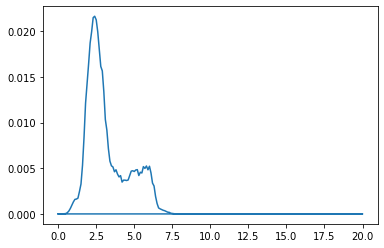

In [22]:
x = z
y1 = Density
plt.plot(x, y1, label = 'PAO')

In [23]:
os.chdir(path_Analyze)

# --------- PAO ---------
wf = open("Data_" + "massd_pao" + ".txt", "w")
wf.write( "Total number of dumps: " + str(len(atoms_traj)) + "\n\n" )
wf.write( "z[A]\tmass_density_pao[g/cm^3]\n" )

#wf.write( "z[Å]\tNDD(C)[/Å^3]\n" )
for i in range( int(FilmThickness/gap) ):
    wf.write(str(round(z[i],2)) + "\t" + str(Density[i]) + "\n")


wf.close()

## 2.1 Cal mass density for stearamide OFM

In [24]:
# 判断之前是否已经保存过基板的[最大][最小]坐标：若没有，则计算并输出保存；若有，则直接读取
# 因为计算一次要花很长时间

# 1. Find Max lower Fe
if not os.path.isfile(path_Analyze + "/Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
  
  os.chdir(path_dumps)
  atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

  for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {19}}))  # Type 17: Fe's type on lower interface

  pro = pp.ProValueArray(atoms_traj)
  pro.select("zu")
  pp.execute_omp(pro)
  results = pro.get_results()
  zu_array_Fe = results["zu"]

  MaxLowerFe = np.zeros(len(atoms_traj))
  for i in range(len(atoms_traj)):
      MaxLowerFe[i] = np.max(zu_array_Fe[i])  # Z_max for Fe in lower interface  
  print(MaxLowerFe)

  os.chdir(path_Analyze)
  np.savetxt("Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", MaxLowerFe, fmt='%f', delimiter=' ')

else:
  print("Will read MaxLowerFe directly from the previous saved file.")

Will read MaxLowerFe directly from the previous saved file.


In [25]:
# Read MaxLowerFe and MinUpperFe from file no matter re-calculated or not.

os.chdir(path_Analyze)
MaxLowerFe = np.loadtxt(
    "Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [26]:
# Get the smallest and largest x-coordinate of oxygen atoms in upper interface

os.chdir(path_dumps)
atoms_traj = [pp.create(
pp.StaDumpAtoms("atom.{}.dump".format(i), i))
for i in range(dump_start, dump_end+2000, dump_interval)]

for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {26}}))  # Type 24: O's type on upper cylinder surface

In [27]:
if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
    if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
        c = pp.ProValueArray(atoms_traj)
        c.select("xu")
        pp.execute_omp(c)
        results = c.get_results()
    
        xu_array_O = results["xu"]
        Min_Oxu = np.zeros(len(atoms_traj))
        Max_Oxu = np.zeros(len(atoms_traj))
        for i in range(len(atoms_traj)):
            Min_Oxu[i] = np.min(xu_array_O[i])
            Max_Oxu[i] = np.max(xu_array_O[i])
        print(Min_Oxu)
        print(Max_Oxu)
    
        os.chdir(path_Analyze)
        np.savetxt("Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Min_Oxu, fmt='%f', delimiter=' ')
        np.savetxt("Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Max_Oxu, fmt='%f', delimiter=' ')
else:
  print("Will read Min_Oxu,Max_Oxu directly from the previous saved file.")

Will read Min_Oxu,Max_Oxu directly from the previous saved file.


In [28]:
os.chdir(path_Analyze)
Min_Oxu = np.loadtxt(
    "Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)
Max_Oxu = np.loadtxt(
    "Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [29]:
#Cylinder下部のMin_Oxu,Max_OxuをWrap
for i in range (len(atoms_traj)):   
    if Min_Oxu[i] < 0:
        while Min_Oxu[i] < 0:
            Min_Oxu[i] +=  box_x
    elif Min_Oxu[i] > box_x:
        while Min_Oxu[i] > box_x:
            Min_Oxu[i] -= box_x

for i in range (len(atoms_traj)):   
    if Max_Oxu[i] < 0:
        while Max_Oxu[i] < 0:
         Max_Oxu[i] +=  box_x
    elif Max_Oxu[i] > box_x:
        while Max_Oxu[i] > box_x:
         Max_Oxu[i] -= box_x

print(Min_Oxu)
print(Max_Oxu)

[24.755 24.84  24.976 ...  1.066  1.166  1.326]
[59.621 59.855 60.    ... 36.046 36.216 36.346]


In [30]:
os.chdir(path_dumps)
atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

In [31]:
len(atoms_traj)

2501

In [32]:
for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {6,7,8,9,10,11,12,13}}))  
    # 1: C     2: C     3: H

pro = pp.ProValueArray(atoms_traj)
pro.select("zu","type","xu")

pp.execute_omp(pro)

results = pro.get_results()

zu_array = results["zu"]
type_array = results["type"]
xu_array = results["xu"]

print(type_array)

[[12. 10. 12. ...  8.  9.  9.]
 [12. 10. 12. ...  8.  9.  9.]
 [12. 10. 12. ...  8.  9.  9.]
 ...
 [12. 10. 12. ...  8.  9.  9.]
 [12. 10. 12. ...  8.  9.  9.]
 [12. 10. 12. ...  8.  9.  9.]]


In [33]:
# total number of atoms selected 

atom_num = 3420        

In [34]:
for i in range (len(atoms_traj)):   
    for j in range (atom_num):    
        if xu_array[i][j] < 0:
            while xu_array[i][j]<0:
                xu_array[i][j] = xu_array[i][j]+box_x
        elif xu_array[i][j] > box_x:
            while xu_array[i][j]>box_x:
                xu_array[i][j] -= box_x
        xu_array[i][j] = round(xu_array[i][j], 4)
print(xu_array)

[[21.65  21.796 22.617 ... 69.738 69.079 70.018]
 [22.126 21.857 22.369 ... 69.817 68.939 70.505]
 [21.858 21.099 20.864 ... 70.021 69.154 70.568]
 ...
 [57.016 57.852 58.567 ... 12.447 11.83  13.22 ]
 [56.372 57.43  58.118 ... 12.389 11.637 13.304]
 [57.586 57.928 58.763 ... 12.398 11.615 13.213]]


In [35]:
Mass_C = np.zeros(5000)
Mass_H = np.zeros(5000) 
Mass_O = np.zeros(5000)
Mass_N = np.zeros(5000)
z = np.zeros(5000) 


for i in range (len(atoms_traj)):
    for j in range (atom_num): 

      layer_C = (zu_array[i][j] - MaxLowerFe[i]) // gap   # 0.3//0.5=0; 0.9//0.5=1.0; 1.1//0.5=2.0

      if Min_Oxu[i] < Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j]<=Max_Oxu[i]:

            if type_array[i][j] == 6 or type_array[i][j] == 10 or type_array[i][j] == 11:
                Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
            
            if type_array[i][j] == 9 or type_array[i][j] == 12 or type_array[i][j] == 13:
                Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

            if type_array[i][j] == 7 :
                Mass_O[int(layer_C)] = Mass_O[int(layer_C)] + 16
            
            if type_array[i][j] == 8 :
                Mass_N[int(layer_C)] = Mass_N[int(layer_C)] + 14



      elif Min_Oxu[i] > Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j] or xu_array[i][j]<=Max_Oxu[i]:

            if type_array[i][j] == 6 or type_array[i][j] == 10 or type_array[i][j] == 11:
                Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
            
            if type_array[i][j] == 9 or type_array[i][j] == 12 or type_array[i][j] == 13:
                Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

            if type_array[i][j] == 7 :
                Mass_O[int(layer_C)] = Mass_O[int(layer_C)] + 16
            
            if type_array[i][j] == 8 :
                Mass_N[int(layer_C)] = Mass_N[int(layer_C)] + 14

      
            
Mass_C = Mass_C / len(atoms_traj)  
Density_C = Mass_C / Volume  
Mass_H = Mass_H / len(atoms_traj)  
Density_H = Mass_H / Volume  
Mass_O = Mass_O / len(atoms_traj)  
Density_O = Mass_O / Volume  
Mass_N = Mass_N / len(atoms_traj)  
Density_N = Mass_N / Volume  

Density_OFM = (Density_C + Density_H + Density_O + Density_N)*(1.661129568)   

print(Density_OFM)

for i in range( int(FilmThickness/gap) ):
    z[i+1] = z[i] + gap

[0.00663249 0.00958571 0.01070649 ... 0.00011813 0.00094791 0.00343437]


In [36]:
os.chdir(path_Analyze)

# --------- OFM ---------
wf = open("Data_" + "massd_stea_OFM" + ".txt", "w")
wf.write( "Total number of dumps: " + str(len(atoms_traj)) + "\n\n" )
wf.write( "z[A]\tmass_density_stea[g/cm^3]\n" )

#wf.write( "z[Å]\tNDD(C)[/Å^3]\n" )
for i in range( int(FilmThickness/gap) ):
    wf.write(str(round(z[i],2)) + "\t" + str(Density_OFM[i]) + "\n")

wf.close()

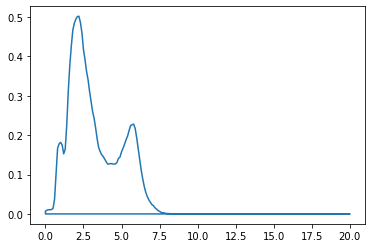

In [37]:
x = z
y2 = Density_OFM

plt.plot(x, y2, label = 'OFM')

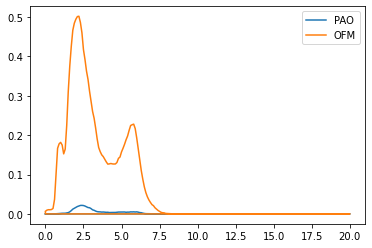

In [38]:
x = z
y1 = Density
plt.plot(x, y1, label = 'PAO')
y2 = Density_OFM
plt.plot(x, y2, label = 'OFM')
plt.legend()
plt.show()

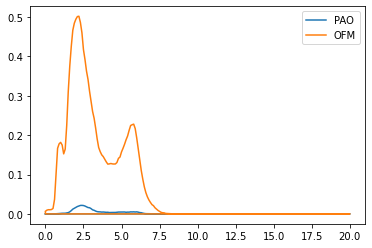

In [39]:
x = z
y1 = Density
plt.plot(x, y1, label = 'PAO')
y2 = Density_OFM
plt.plot(x, y2, label = 'OFM')
plt.legend()
plt.show()